In [135]:
import pandas as pd
import numpy as np
import ppscore as pps
import plotly.express as px
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
import xgboost as xgb
# import warnings
# warnings.filterwarnings('ignore')

In [136]:
# read in dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train.Survived
train.shape

(891, 12)

In [137]:
# survived is dependent variable
var = train.columns
target = 'Survived'
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
512,513,1,1,"McGough, Mr. James Robert",male,36.0,0,0,PC 17473,26.2875,E25,S
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C


In [138]:
print(f"Survival rate of {round(train.Survived.sum() / train.Survived.count(),3) * 100} %")

Survival rate of 38.4 %


In [139]:
'''
before doing anything else we will create folds using stratified sampling
cannot use randon k-fold cross validation as we'd like to keep a constant survival
ratio across folds
'''

"\nbefore doing anything else we will create folds using stratified sampling\ncannot use randon k-fold cross validation as we'd like to keep a constant survival\nratio across folds\n"

In [140]:
# create kfold column filled with -1
train['kfold'] = -1

# next we have to randomize the rows of data
train = train.sample(frac=1).reset_index(drop = True)

# specify target variable
y = train.Survived.values

# initiate the kfold class from model_selection module
kf = model_selection.KFold(n_splits=5)

# fill the new kfold columnm
for f, (t_,v_) in enumerate(kf.split(X=train,y=y)):
    train.loc[v_,'kfold'] = f

# save the new csv with kfold column
train.to_csv('train_folds.csv')

In [141]:
df = pd.read_csv('train_folds.csv')

### Classify variables

- Categorical variables: Survived, Sex, Cabin, Embarked
- Ordinal variables: Pclass
- Continuous variables: Age, Fare
- Discrete variables: SibSp, Parch

In [108]:
# check to see how many values are missing
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    int64  
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
 13  Last_name    891 non-null    object 
 14  title        891 non-null    object 
 15  first_name   891 non-null    object 
 16  kfold        891 non-null    int64  
dtypes: float64(2), int64(7), object(8)
memory usage: 118.5+ KB


- many cabin selections are missing, ages are also missing and a few embarked values are missing
- Name, Sex, Ticket, Cabin, Embarked are all objects

In [112]:
# we will fill cabin values with NONE
df.Cabin = df.Cabin.fillna('NONE')
df.Embarked = df.Embarked.fillna('NONE')

In [126]:
df.Name.value_counts()

Jerwan, Mrs. Amin S (Marie Marthe Thuillard)             1
Carter, Mrs. Ernest Courtenay (Lilian Hughes)            1
Harmer, Mr. Abraham (David Lishin)                       1
Smith, Mr. James Clinch                                  1
Shellard, Mr. Frederick William                          1
                                                        ..
Robert, Mrs. Edward Scott (Elisabeth Walton McMillan)    1
Elias, Mr. Joseph Jr                                     1
Harknett, Miss. Alice Phoebe                             1
Sadlier, Mr. Matthew                                     1
Lines, Miss. Mary Conover                                1
Name: Name, Length: 891, dtype: int64

In [127]:
# create a feature that splits names
df[['Last_name','title','first_name']] = df.Name.str.split(' ', expand = True).iloc[:,0:3]

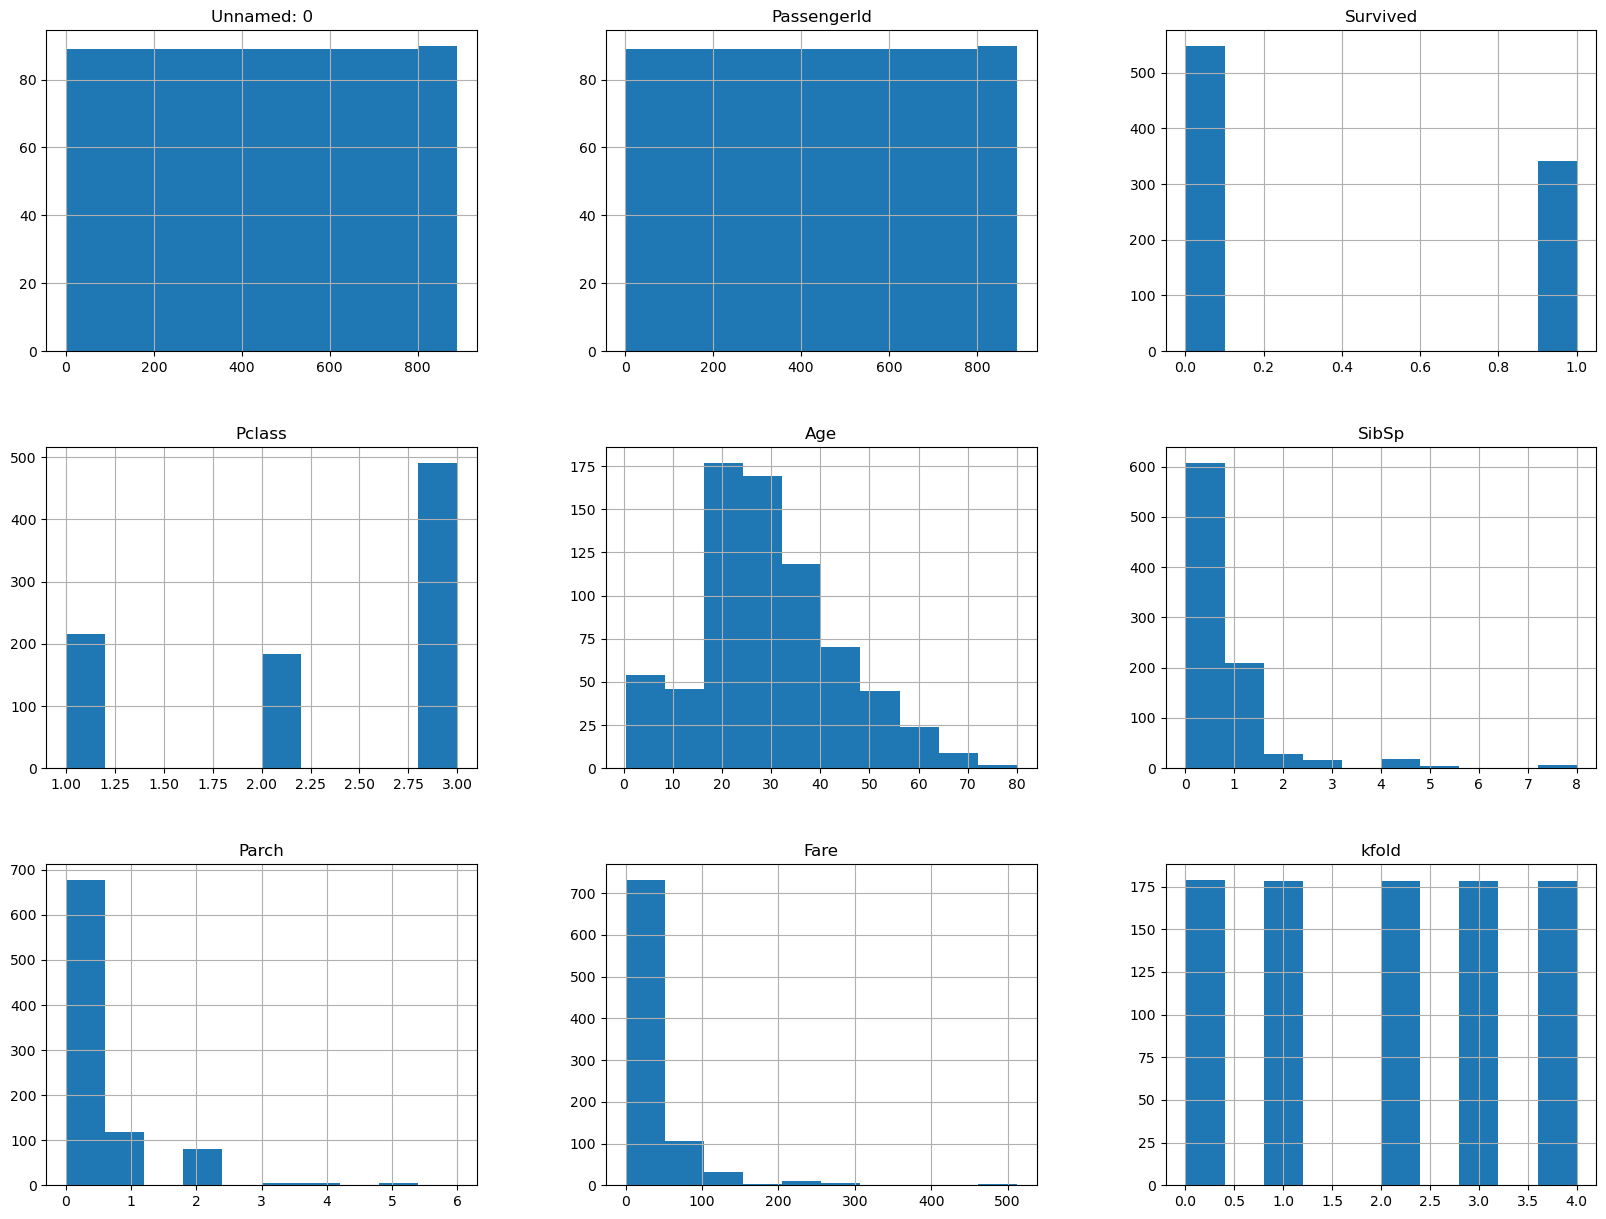

In [131]:
# let's look at a distribution of numerical values
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins = 10,
             figsize = (20,15))
plt.show()

### Observations
- more people died than survived
- most people were in third class
- most values for sibsp are zero meaning passengers travelled without a spouse or sibling though might been travelling with a fiance
- Parch values mostly zero meaning most passengers were travelling with their partner
- Fares look reasonable except for the large fare that was more than 500

In [132]:
# let's look at a correlation matrix
# now lets look for correlations
corr_matrix = df.corr()
corr_matrix['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
kfold         -0.003641
PassengerId   -0.005007
SibSp         -0.035322
Unnamed: 0    -0.037649
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

### observations
- correlations aren't very strong
- limitation is it only checks for linear relationships
- there might be other relationships we need to investigate

<AxesSubplot:xlabel='x', ylabel='y'>

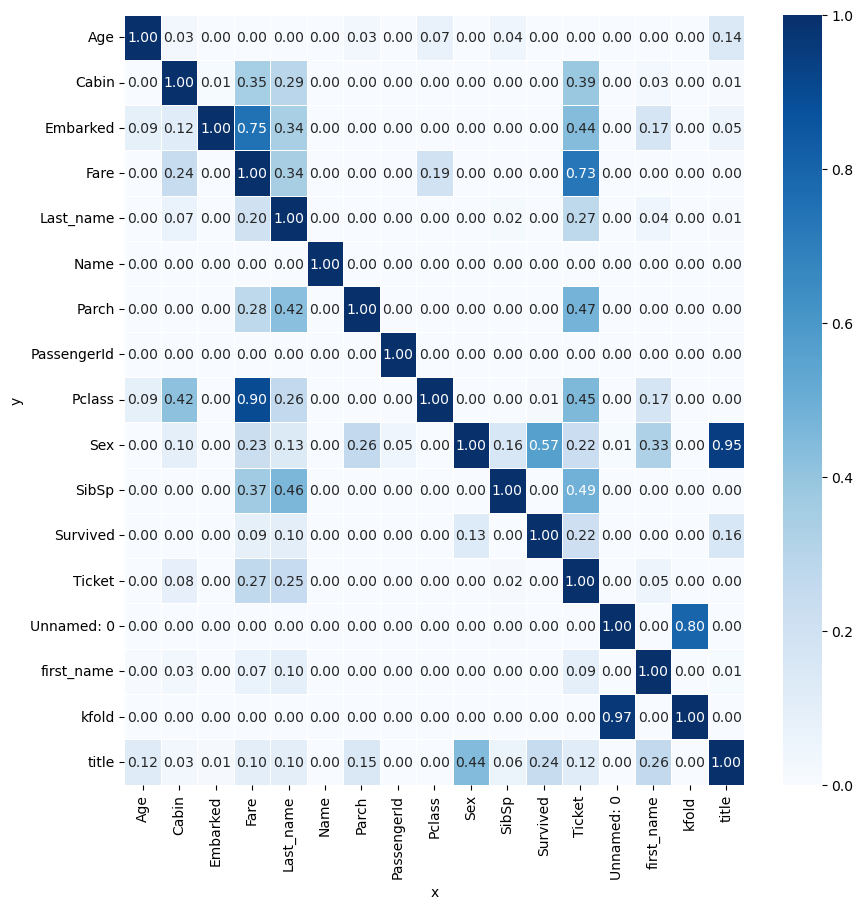

In [133]:
# explore some of the missing variables
fig, ax = plt.subplots(figsize = (10,10))
ppscores = pps.matrix(df)
ppscores = ppscores[["x", "y", "ppscore"]].pivot(columns="x", index="y", values="ppscore")
sns.heatmap(
    ppscores, 
    vmin=0, 
    vmax=1, 
    cmap="Blues", 
    linewidths=0.7, 
    annot=True,
    fmt = '.2f'
)

### Observations from PPSCORE
- cabin, fare are a strong predictor of class which intuitively makes sense
- title is a very strong predictor of sex
- ticket has strong relationships with a number of variables

In [ ]:
# still need to fill in many missing age values
# unfortunately it doens't appear that there are many relationships with age
# we will fill with the median

In [ ]:
# need to add feature scaling as many ML algos won't perform well without it
# need to add cross validation

In [ ]:
# feature scaling, with few exceptions ML algos don't perform well without scaling
# numerical values
# two common ways are min max scaling and standardization
# lets build a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler()),
])

using_num_tr = num_pipeline.fit_transform(housing_num)

In [92]:
# observe that the values are limited to a set of values
# we can one hot encode them
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
train_1hot = cat_encoder.fit_transform(train)
train_1hot

<891x4100 sparse matrix of type '<class 'numpy.float64'>'
	with 13365 stored elements in Compressed Sparse Row format>

In [94]:
# store the data as a sparse array to conserve memory
train_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [96]:
# now time to select and train models
# first up is Linear Regression!
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_1hot, y)

from sklearn.metrics import precision_score

titanic_predictions = lin_reg.predict(train_1hot)
lin_mse = precision_score(y, titanic_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [51]:
train['kfold'] = -1
train.sample(frac=1).reset_index(drop = True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_name,title,first_name,kfold
0,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S,"Jensen,",Mr.,Hans,-1
1,810,1,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,1,0,113806,53.1000,E8,S,"Chambers,",Mrs.,Norman,-1
2,783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S,"Long,",Mr.,Milton,-1
3,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,van,"Melkebeke,",Mr.,-1
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"Futrelle,",Mrs.,Jacques,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S,"Bateman,",Rev.,Robert,-1
887,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S,"Sage,",Miss.,Stella,-1
888,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S,"Todoroff,",Mr.,Lalio,-1
889,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S,"Mitchell,",Mr.,Henry,-1


In [52]:
train.sample(frac=1).reset_index(drop = True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_name,title,first_name,kfold
0,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"Allen,",Mr.,William,-1
1,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S,"Colley,",Mr.,Edward,-1
2,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,"Robert,",Mrs.,Edward,-1
3,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,"Farthing,",Mr.,John,-1
4,371,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,C,"Harder,",Mr.,George,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,S,"Cherry,",Miss.,Gladys,-1
887,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S,"Kvillner,",Mr.,Johan,-1
888,500,0,3,"Svensson, Mr. Olof",male,24.0,0,0,350035,7.7958,NaN,S,"Svensson,",Mr.,Olof,-1
889,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S,"Clifford,",Mr.,George,-1


In [57]:
kf = model_selection.StratifiedKFold(n_splits = 5)

In [58]:
for f, (t_,v_) in enumerate(kf.split(X=train, y=y)):
        train.loc[v_,'kfold'] = f

In [59]:
train.to_csv('train_folds.csv')

In [64]:
# function for cross validation

def run(fold):

    # load the full training data with folds
    df = pd.read_csv("train_folds.csv")
    
    # all columns are features except id, target, and 
    # kfold columns 
    features = [
        f for f in df.columns if f not in ('PassengerId','Survived','kfold')
    ]

    # fill all NaN values with NONE
    # note that I am converting all columns to "strings"
    # it doesn't matter because all are categories

    for col in features:
        df.loc[:,col] = df[col].astype(str).fillna('NONE')
    
    # now its time to label encode the features
    for col in features:

        # initialize label encoder for each feature column
        lbl = preprocessing.LabelEncoder()

        # fit label encoder on all data
        lbl.fit(df[col])

        # transform all the data
        df.loc[:,col] = lbl.transform(df[col])

    # get training data using folds
    df_train = df[df.kfold != fold].reset_index(drop=True)

    #get validation data using folds
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    # get training data
    x_train = df_train[features].values

    # get validation data
    x_valid = df_valid[features].values

    # initialize xgboost model
    model = xgb.XGBClassifier(
        n_jobs=-1,
        max_depth=7,
        n_estimators=200
    )
    
    # fit model on training data (ohe)
    model.fit(x_train,df_train.Survived.values)

    # predict on validation data
    # we need the probability values as we are calculating AUC
    # we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:,1]

    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.Survived.values,
    valid_preds)

    # print auc
    print(f"Fold = {fold}, AUC = {auc}")
    return model, features

In [65]:
if __name__ == "__main__":
    for fold_ in range(5):
        run(fold_)

/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 0, AUC = 0.8144927536231884
[19:58:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 1, AUC = 0.7864973262032086
[19:58:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric u

/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fold = 3, AUC = 0.8622994652406418
[19:58:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold = 4, AUC = 0.8766121526392767


/Users/lucasshwed/miniconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [66]:
fold = 1
# load the full training data with folds
df = pd.read_csv("test.csv")

# all columns are features except id, target, and 
# kfold columns 
features = [
    f for f in df.columns if f not in ('PassengerId','Survived','kfold')
]

# fill all NaN values with NONE
# note that I am converting all columns to "strings"
# it doesn't matter because all are categories

for col in features:
    df.loc[:,col] = df[col].astype(str).fillna('NONE')

# now its time to label encode the features
for col in features:

    # initialize label encoder for each feature column
    lbl = preprocessing.LabelEncoder()

    # fit label encoder on all data
    lbl.fit(df[col])

    # transform all the data
    df.loc[:,col] = lbl.transform(df[col])

# # get training data using folds
# df_train = df[df.kfold != fold].reset_index(drop=True)

# #get validation data using folds
# df_valid = df[df.kfold == fold].reset_index(drop=True)

# # get training data
# x_train = df_train[features].values

# # get validation data
# x_valid = df_valid[features].values

# # initialize xgboost model
# model = xgb.XGBClassifier(
#     n_jobs=-1,
#     max_depth=7,
#     n_estimators=200
# )

# # fit model on training data (ohe)
# model.fit(x_train,df_train.Survived.values)

# predict on validation data
# we need the probability values as we are calculating AUC
# we will use the probability of 1s
valid_preds = model.predict_proba(df[features].values)[:,1]

# # get roc auc score
# auc = metrics.roc_auc_score(df_valid.Survived.values,
# valid_preds)

# # print auc
# print(f"Fold = {fold}, AUC = {auc}")

NameError: name 'model' is not defined